# breast-cancer-w-feature-selection-dimensionality

Use the "Run" button to execute the code.

# 1. Introduction
In this notebook, we will explore various feature selection and dimensionality reduction techniques in reference to the [Wisconsin breast cancer dataset](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data) on [Kaggle](https://www.kaggle.com/). This dataset contains 569 breast cancer observations in which **357** of them are **benign** and **212** of them are **malignant**. The goal is to train a machine learning model that is able to classify a random breast cancer observation as either benign or malignant. I have chosen the `random forest classifier` for this particular problem.

The techniques that will be covered in this notebook as follows:

* Variance inflation factor (VIF)
* Univariate feature selection
* Recursive feature elimination
* Model-based feature selection
* Principal component analysis (PCA)

We will compare the effectiveness of each technique by examining the accuracy of our model at making predictions. More specifically, we will be using the confusion matrix, which is a common approach to test the performance of a model in binary classification.

In [1]:
!pip install jovian --upgrade --quiet

In [2]:
import jovian

In [3]:
# Execute this to save new versions of the notebook
jovian.commit(project="breast-cancer-w-feature-selection-dimensionality")

<IPython.core.display.Javascript object>

[jovian] Updating notebook "kartikaye-madhok/breast-cancer-w-feature-selection-dimensionality" on https://jovian.ai
[jovian] Committed successfully! https://jovian.ai/kartikaye-madhok/breast-cancer-w-feature-selection-dimensionality


'https://jovian.ai/kartikaye-madhok/breast-cancer-w-feature-selection-dimensionality'

In [4]:
!pip install opendatasets --upgrade --quiet

# 2. Import Libraries

In [5]:
#Data Importing
import opendatasets as od
import os

# Data wrangling
import pandas as pd
import numpy as np

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, RFE, RFECV
from sklearn.decomposition import PCA

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

# 3. Import and Read Data

In [6]:
dataset_url = 'https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data'


In [7]:
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: kartikayemadhok
Your Kaggle Key: ········


100%|██████████| 48.6k/48.6k [00:00<00:00, 36.6MB/s]

In [8]:
data_dir = './breast-cancer-wisconsin-data'

In [9]:
os.listdir(data_dir)

['data.csv']

In [10]:
data_df=pd.read_csv('breast-cancer-wisconsin-data/data.csv')
data_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [11]:
data_df.shape

(569, 33)

The dataset contains **569 rows and 33 columns**. 

# 4. Check for Missing Values

In [12]:
# Missing data

missing = data_df.isnull().sum().sort_values(ascending = False)
missing

Unnamed: 32                569
compactness_se               0
fractal_dimension_worst      0
symmetry_worst               0
concave points_worst         0
concavity_worst              0
compactness_worst            0
smoothness_worst             0
area_worst                   0
perimeter_worst              0
texture_worst                0
radius_worst                 0
fractal_dimension_se         0
symmetry_se                  0
concave points_se            0
concavity_se                 0
id                           0
diagnosis                    0
area_se                      0
perimeter_se                 0
texture_se                   0
radius_se                    0
fractal_dimension_mean       0
symmetry_mean                0
concave points_mean          0
concavity_mean               0
compactness_mean             0
smoothness_mean              0
area_mean                    0
perimeter_mean               0
texture_mean                 0
radius_mean                  0
smoothne

Unnamed is the only column with missing values in the dataframe. In fact, the entire column is missing so it is safe for us to drop the column.

I will also remove the id column as it does not provide us with any information regarding the classification of cancer cells.

In [13]:
# Drop ID and Unnamed columns

print("Before:", data_df.shape)
data_df = data_df.drop(['id', 'Unnamed: 32'], axis = 1)
print("After:", data_df.shape)

Before: (569, 33)
After: (569, 31)


# 5. Data Description

In [14]:
data_df.dtypes.value_counts()

float64    30
object      1
dtype: int64

Out of the 31 columns left in the data set, **30 are numeric [float64] and 1 is a categorical column**, which incidently is our target variable (diagnosis).

In [15]:
data_df.dtypes

diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst            float64
concave points_worst

According to the data description of this dataset, the columns represent 10 real-valued features of each cell nucleus:

* Radius
* Texture
* Perimeter
* Area
* Smoothness
* Compactness
* Concavity
* Concave points
* Symmetry
* Fractal dimension

The mean, standard error and worst of each feature were also computed, resulting in a total of 10 x 3 = 30 features (columns) in the dataset excluding the target variable.

Just by the names of the features itself, we can already foresee some issues of multicollinearity. The most obvious being between radius, perimeter and area. But before we deal with the issue of multicollinearity, let's first standardise our data and divide the features into 3 groups:

1. feature_mean

2. feature_se

3. feature_worst

In [16]:
# Standardise all features so that they follow a standard Gaussian distribution

original_features = data_df.drop('diagnosis', axis = 1)
standard_features = (original_features - original_features.mean()) / original_features.std()
standard_data = pd.concat([data_df['diagnosis'], standard_features], axis = 1)

In [17]:
# Divide the standardised features into 3 groups 

feature_mean = standard_data.iloc[:, 1:11]
feature_se = standard_data.iloc[:, 11: 21]
feature_worst = standard_data.iloc[:, 21:31]

Now, we can move on to exploring the features in the dataset.

# 6. Exploratory Data Analysis

In [18]:
standard_data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,...,1.885031,-1.358098,2.301575,1.999478,1.306537,2.614365,2.107672,2.294058,2.748204,1.935312
1,M,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,...,1.804340,-0.368879,1.533776,1.888827,-0.375282,-0.430066,-0.146620,1.086129,-0.243675,0.280943
2,M,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,...,1.510541,-0.023953,1.346291,1.455004,0.526944,1.081980,0.854222,1.953282,1.151242,0.201214
3,M,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,...,-0.281217,0.133866,-0.249720,-0.549538,3.391291,3.889975,1.987839,2.173873,6.040726,4.930672
4,M,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,...,1.297434,-1.465481,1.337363,1.219651,0.220362,-0.313119,0.612640,0.728618,-0.867590,-0.396751


## 6.1 Target Variables

In [20]:
# Encode target variable

data_df['diagnosis'] = data_df['diagnosis'].map({'B': 0, 'M': 1})
standard_data['diagnosis'] = standard_data['diagnosis'].map({'B': 0, 'M': 1})

In [22]:
# Value counts

target = data_df['diagnosis']
target.value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

There are more cancer cells that are benign than there are that are malignant.

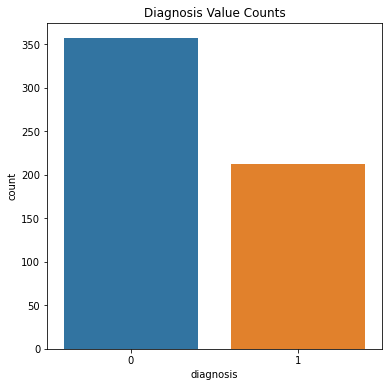

In [24]:
total = len(data_df)
plt.figure(figsize = (6, 6))
plt.title('Diagnosis Value Counts')
ax = sns.countplot(target)

plt.show()

## 6.2 Predictor Variables

### 6.2.1 Issue of Multicollinearity

<AxesSubplot:title={'center':'Correlation Between Predictor Variables'}>

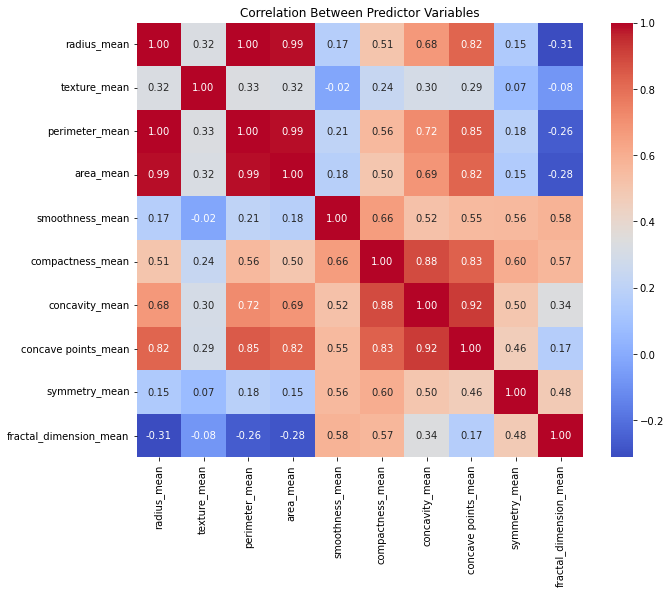

In [25]:
# Heatmap

correlation = feature_mean.corr()
plt.figure(figsize = (10, 8))
plt.title('Correlation Between Predictor Variables')
sns.heatmap(correlation, annot = True, fmt = '.2f', cmap = 'coolwarm')

As expected, we have a severe problem of multicollinearity in our data. From the heatmap, we can observe that the following features are positively correlated **(Dark Shades Of Red)** with each other:

* Radius
* Perimeter
* Area
* Compactness
* Concavity
* Concave points

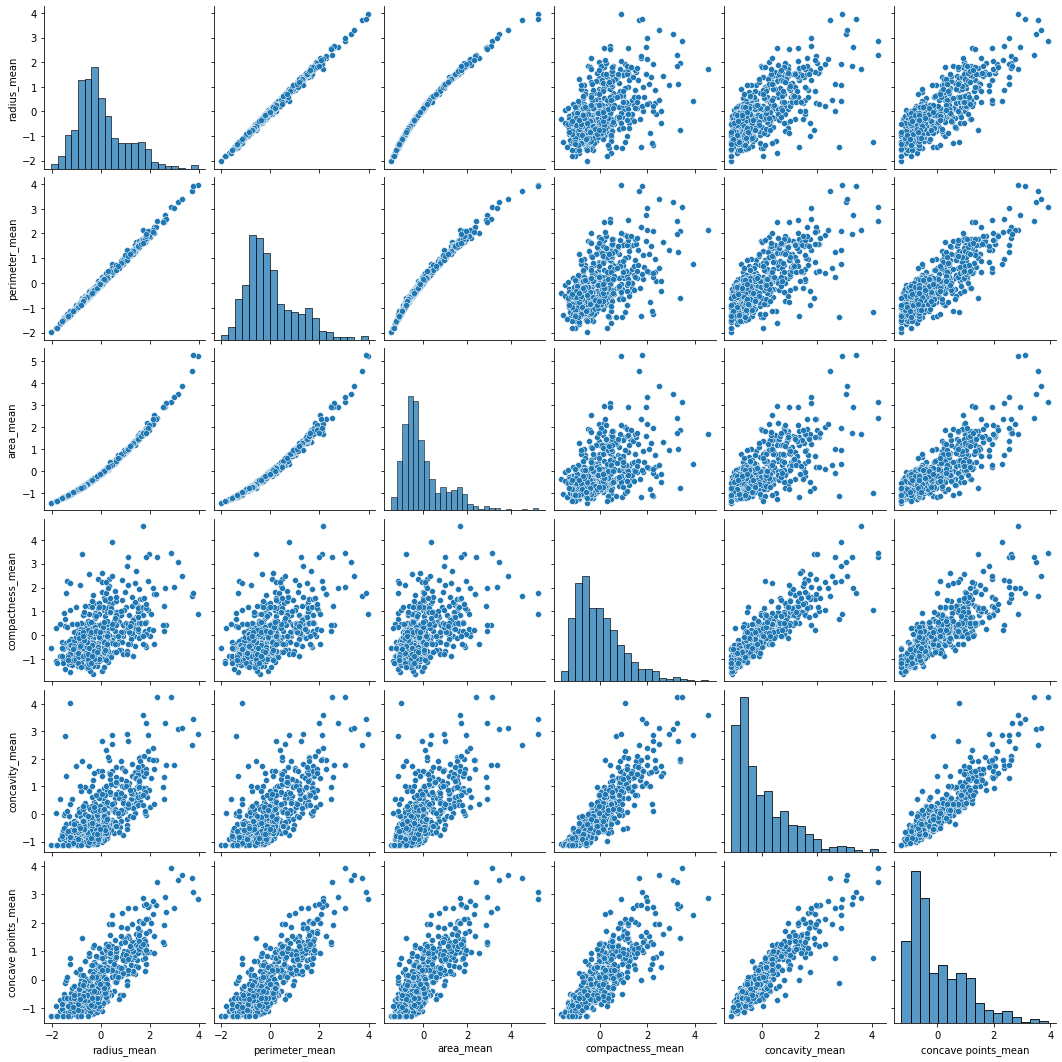

In [26]:
# Pairplot between correlated features

sns.pairplot(feature_mean[['radius_mean', 'perimeter_mean', 'area_mean', 'compactness_mean', 'concavity_mean', 'concave points_mean']])

### 6.2.2 Explore the relationship between Predictor Variables and Target Variables

In this section, we will visualise the relationship between our predictor variables and the target variable. The goal here is to investigate and determine the features that are most important at distinguishing whether a cancer cell is benign or malignant.

In [27]:
feature_mean = pd.concat([target, feature_mean], axis=1)
feature_mean.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,1,1.096100,-2.071512,1.268817,0.983510,1.567087,3.280628,2.650542,2.530249,2.215566,2.253764
1,1,1.828212,-0.353322,1.684473,1.907030,-0.826235,-0.486643,-0.023825,0.547662,0.001391,-0.867889
2,1,1.578499,0.455786,1.565126,1.557513,0.941382,1.052000,1.362280,2.035440,0.938859,-0.397658
3,1,-0.768233,0.253509,-0.592166,-0.763792,3.280667,3.399917,1.914213,1.450431,2.864862,4.906602
4,1,1.748758,-1.150804,1.775011,1.824624,0.280125,0.538866,1.369806,1.427237,-0.009552,-0.561956


In [28]:
mean_melt = pd.melt(feature_mean, id_vars = 'diagnosis', var_name = 'feature', value_name = 'value')
mean_melt.tail()

,diagnosis,feature,value
5685,1,fractal_dimension_mean,-0.930209
5686,1,fractal_dimension_mean,-1.057681
5687,1,fractal_dimension_mean,-0.894800
5688,1,fractal_dimension_mean,1.042778
5689,0,fractal_dimension_mean,-0.560539


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'radius_mean'),
  Text(1, 0, 'texture_mean'),
  Text(2, 0, 'perimeter_mean'),
  Text(3, 0, 'area_mean'),
  Text(4, 0, 'smoothness_mean'),
  Text(5, 0, 'compactness_mean'),
  Text(6, 0, 'concavity_mean'),
  Text(7, 0, 'concave points_mean'),
  Text(8, 0, 'symmetry_mean'),
  Text(9, 0, 'fractal_dimension_mean')])

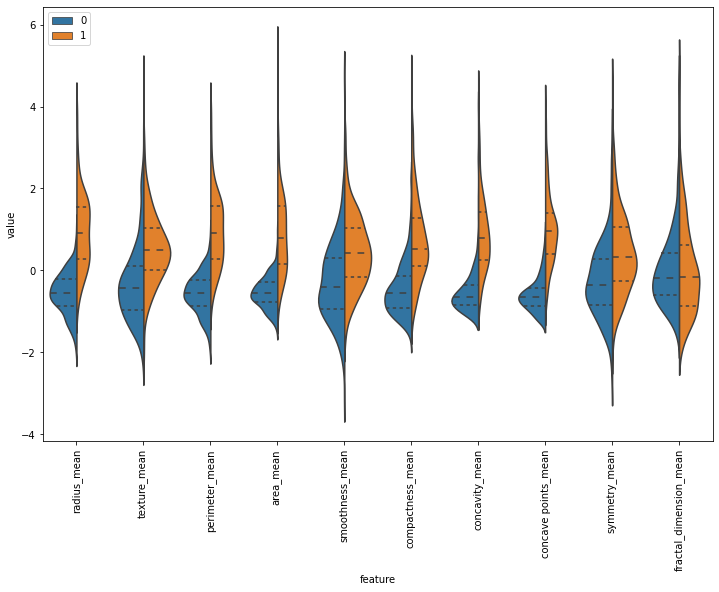

In [29]:
# Violinplot

plt.figure(figsize = (12, 8))
sns.violinplot(x = 'feature', y = 'value', hue = 'diagnosis', data = mean_melt, split = True, inner = 'quart')
plt.legend(loc = 2)
plt.xticks(rotation = 90)

Besides fractal dimension, all the features look promising at classifying cancer cells.

We can see that cancer cells that are malignant tend to have higher values in all of the features.

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'radius_mean'),
  Text(1, 0, 'texture_mean'),
  Text(2, 0, 'perimeter_mean'),
  Text(3, 0, 'area_mean'),
  Text(4, 0, 'smoothness_mean'),
  Text(5, 0, 'compactness_mean'),
  Text(6, 0, 'concavity_mean'),
  Text(7, 0, 'concave points_mean'),
  Text(8, 0, 'symmetry_mean'),
  Text(9, 0, 'fractal_dimension_mean')])

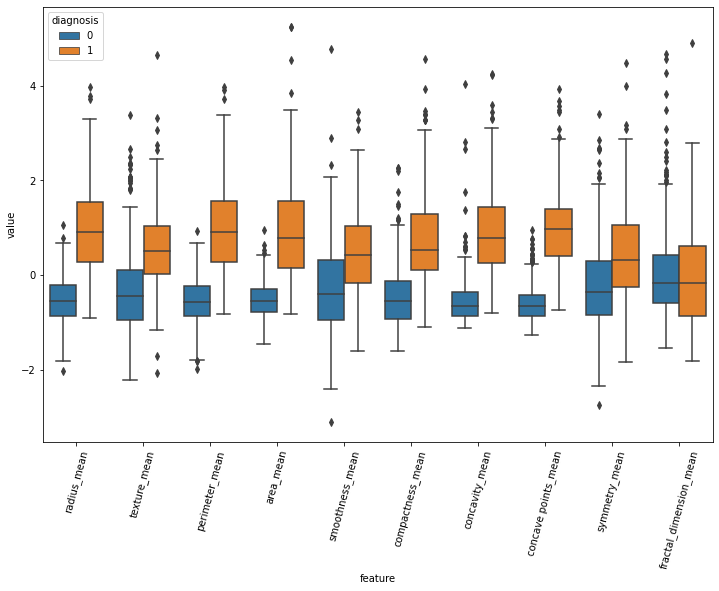

In [30]:
# Boxplot

plt.figure(figsize = (12, 8))
sns.boxplot(x = 'feature', y = 'value', hue = 'diagnosis', data = mean_melt)
plt.xticks(rotation = 75)

Again, this plot illustrates that fractal dimension is not as good at classifying cancer cells as the other features in the dataset.

Boxplot also allows us to analyse the outliers in our dataset but let's ignore this problem for now.

# 7. Feature Selection

Now that we have a better sense of our data, we can move on to selecting features for our training set to build our model.

Before we do that, let's set a base case for our feature selection i.e. use all the features in the dataset to train our model.

Here, I will assign 75% of the dataset as the training set and the remaining 25% as the test set to test the accuracy of our model.

In [31]:
# Train test split 

X_train, X_test, Y_train, Y_test = train_test_split(original_features, target, test_size = 0.25, random_state = 42)
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", Y_train.shape)
print("X_test shape: ", X_test.shape)
print("Y_test shape: ", Y_test.shape)

X_train shape:  (426, 30)
Y_train shape:  (426,)
X_test shape:  (143, 30)
Y_test shape:  (143,)


## 7.1 Base Case

In [32]:

# Fit random forest classifier to training set and make predictions on test set

rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)

Accuracy: 96.50%
F1 score: 0.95


<AxesSubplot:>

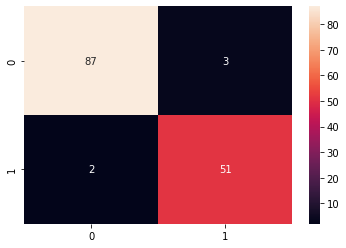

In [33]:
# Evaluate model accuracy 

accuracy = accuracy_score(Y_pred, Y_test) * 100
print("Accuracy: {:.2f}%".format(accuracy))
f1 = f1_score(Y_pred, Y_test)
print("F1 score: {:.2f}".format(f1))
cm = confusion_matrix(Y_pred, Y_test)
sns.heatmap(cm, annot = True, fmt = 'd')

Our model achieved an accuracy of 96.5%. Not too shabby at all.

Let's now explore the different feature selection and dimensionality reduction techniques and see if we can achieve a similar level of accuracy but with a smaller training set i.e. less features.

## 7.2 Variance inflation factor (VIF)

In [34]:
# Define a function which computes VIF

def calculate_vif(df):
    vif = pd.DataFrame()
    vif['Feature'] = df.columns
    vif['VIF'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return (vif)

In [35]:
# Construct VIF dataframe

vif_table = calculate_vif(original_features)
vif_table = vif_table.sort_values(by = 'VIF', ascending = False, ignore_index = True)
vif_table

,Feature,VIF
0,radius_mean,63306.172036
1,perimeter_mean,58123.586079
2,radius_worst,9674.742602
3,perimeter_worst,4487.781270
4,area_mean,1287.262339
5,area_worst,1138.759252
6,fractal_dimension_mean,629.679874
7,fractal_dimension_worst,423.396723
8,smoothness_mean,393.398166
9,smoothness_worst,375.597155


In [39]:
# Top 5 features with highest VIF

features_to_drop = list(vif_table['Feature'])[:5]
features_to_drop

['radius_mean',
 'perimeter_mean',
 'radius_worst',
 'perimeter_worst',
 'area_mean']

Unsurprisingly, the top 5 features with the highest VIF are the suspects that we have already identified earlier on.

In [40]:
# Drop top 5 features with highest VIF

new_features = original_features.drop(features_to_drop, axis = 1)

Accuracy: 95.80%
F1 score: 0.94


<AxesSubplot:>

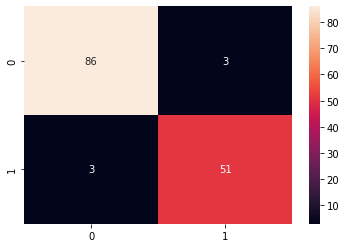

In [41]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(new_features, target, test_size = 0.25, random_state = 42)

# Fit model to data and make predictions
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)

# Evaluate model accuracy 
accuracy = accuracy_score(Y_pred, Y_test) * 100
print("Accuracy: {:.2f}%".format(accuracy))
f1 = f1_score(Y_pred, Y_test)
print("F1 score: {:.2f}".format(f1))
cm = confusion_matrix(Y_pred, Y_test)
sns.heatmap(cm, annot = True, fmt = 'd')

After removing the top 5 features with the highest VIF, our model accuracy decreased marginally.

## 7.3 Univariate feature selection

In [42]:
# Train test split

X_train, X_test, Y_train, Y_test = train_test_split(original_features, target, test_size = 0.25, random_state = 42)

In [43]:
# Instantiate select features
select_features = SelectKBest(chi2, k = 5).fit(X_train, Y_train)

# Top 5 features
selected_features = select_features.get_support()
print("Top 5 features: ", list(X_train.columns[selected_features]))

Top 5 features:  ['perimeter_mean', 'area_mean', 'area_se', 'perimeter_worst', 'area_worst']


Accuracy: 96.50%
F1 score: 0.95


<AxesSubplot:>

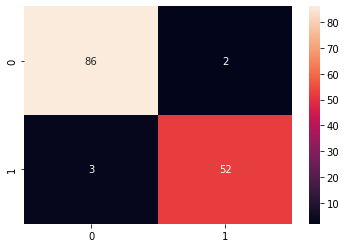

In [44]:
# Apply select features to training and test set
X_train = select_features.transform(X_train)
X_test = select_features.transform(X_test)

# Fit model to data and make predictions
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)

# Evaluate model accuracy 
accuracy = accuracy_score(Y_pred, Y_test) * 100
print("Accuracy: {:.2f}%".format(accuracy))
f1 = f1_score(Y_pred, Y_test)
print("F1 score: {:.2f}".format(f1))
cm = confusion_matrix(Y_pred, Y_test)
sns.heatmap(cm, annot = True, fmt = 'd')

Wow, this is remarkable!

Despite only using 5 features (1/6 of the original trainining set), our model accuracy has only gone up by 1.2%. This goes to show that these 5 features contain most of the information that is needed by our model to classify cancer cells accurately.

## 7.4 Recursive feature elimination

In [45]:
# Train test split

X_train, X_test, Y_train, Y_test = train_test_split(original_features, target, test_size = 0.25, random_state = 42)

In [46]:
# Instantiate recursive feature elimination to select the top 5 features
rf = RandomForestClassifier(random_state = 42)
rfe = RFE(estimator = rf, n_features_to_select = 5).fit(X_train, Y_train)

# Top 5 features
print("Top 5 features: ", list(X_train.columns[rfe.support_]))

Top 5 features:  ['concave points_mean', 'radius_worst', 'perimeter_worst', 'area_worst', 'concave points_worst']


The top 5 features chosen under recursive feature elimination are slightly different to those selected under univariate feature selection.

Let's now test the model accuracy.

Accuracy: 95.80%
F1 score: 0.94


<AxesSubplot:>

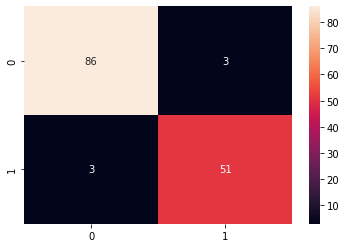

In [47]:
# Make predictions on test set
Y_pred = rfe.predict(X_test)

# Evaluate model accuracy 
accuracy = accuracy_score(Y_pred, Y_test) * 100
print("Accuracy: {:.2f}%".format(accuracy))
f1 = f1_score(Y_pred, Y_test)
print("F1 score: {:.2f}".format(f1))
cm = confusion_matrix(Y_pred, Y_test)
sns.heatmap(cm, annot = True, fmt = 'd')

Again, we achieved an accuracy of 95%, similar to that under Variance Inflation Factor.

## 7.5 Model-based feature selection

In [49]:

# Train test split

X_train, X_test, Y_train, Y_test = train_test_split(original_features, target, test_size = 0.25, random_state = 42)

In [50]:
# Fit model to data

rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, Y_train)
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis = 0)
indices = np.argsort(importances)[::-1]

In [51]:
# Evaluate feature importances

print("Feature ranking: ")
for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" %(f + 1, indices[f], importances[indices[f]]))

Feature ranking: 
1. feature 27 (0.172295)
2. feature 23 (0.123192)
3. feature 7 (0.090299)
4. feature 6 (0.083215)
5. feature 20 (0.081277)
6. feature 22 (0.071388)
7. feature 2 (0.053146)
8. feature 13 (0.043551)
9. feature 3 (0.042780)
10. feature 0 (0.039711)
11. feature 26 (0.031740)
12. feature 10 (0.019517)
13. feature 21 (0.016490)
14. feature 25 (0.015801)
15. feature 1 (0.014604)
16. feature 28 (0.013103)
17. feature 5 (0.011402)
18. feature 24 (0.010335)
19. feature 12 (0.008682)
20. feature 4 (0.008165)
21. feature 16 (0.007014)
22. feature 19 (0.006583)
23. feature 29 (0.005182)
24. feature 17 (0.005047)
25. feature 14 (0.004644)
26. feature 11 (0.004600)
27. feature 8 (0.004435)
28. feature 9 (0.004434)
29. feature 18 (0.003714)
30. feature 15 (0.003655)


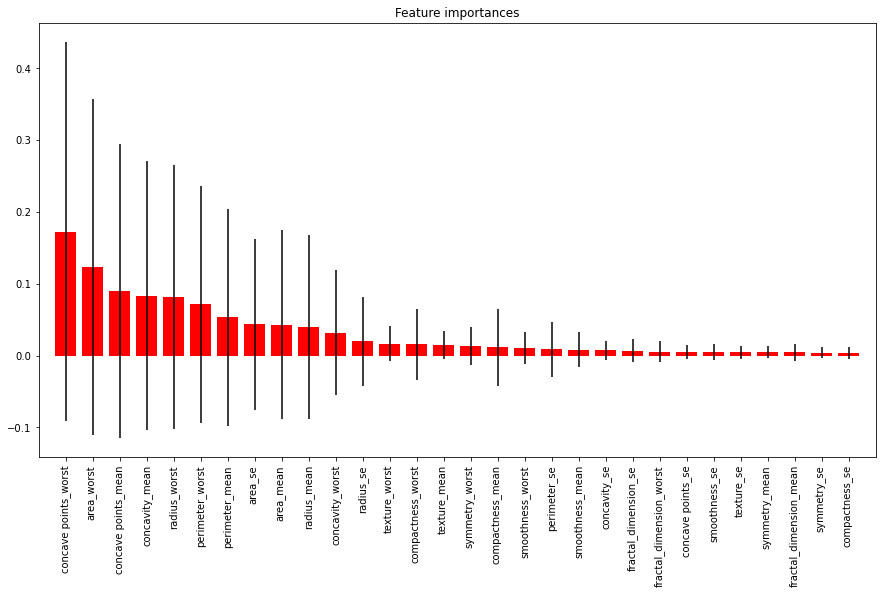

In [52]:
# Plot feature importances

plt.figure(figsize = (15, 8))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color = "r", yerr = std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation = 90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [54]:
# Select features with importances above 5%

new_features = original_features.iloc[:, list(indices)[:9]]
print("Number of features above 5%: ", len(new_features.columns))
list(new_features.columns) 

Number of features above 5%:  9


['concave points_worst',
 'area_worst',
 'concave points_mean',
 'concavity_mean',
 'radius_worst',
 'perimeter_worst',
 'perimeter_mean',
 'area_se',
 'area_mean']

This part is slightly subjective but I decided to only retain features that have importances over 5% as the training set.

Accuracy: 97.08%
F1 score: 0.96


<AxesSubplot:>

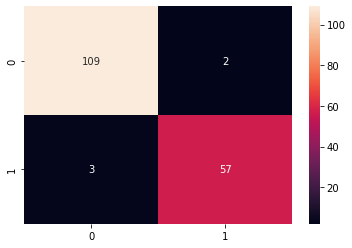

In [56]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(new_features, target, test_size = 0.3, random_state = 10)

# Fit model to data and make predictions
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)

# Evaluate model accuracy 
accuracy = accuracy_score(Y_pred, Y_test) * 100
print("Accuracy: {:.2f}%".format(accuracy))
f1 = f1_score(Y_pred, Y_test)
print("F1 score: {:.2f}".format(f1))
cm = confusion_matrix(Y_pred, Y_test)
sns.heatmap(cm, annot = True, fmt = 'd')

With only 9 features, our model accuracy came very close to that under the base case scenario i.e. 98.25%.

## 7.6 Principal Component Analysis (PCA)

In [58]:
# Train test split using standardised features

X_train, X_test, Y_train, Y_test = train_test_split(standard_features, target, test_size = 0.25, random_state = 42)

In [59]:
# Instantiate and fit PCA to training set

pca = PCA()
pca.fit(X_train)

PCA()

Text(0, 0.5, 'Explained variance ratio')

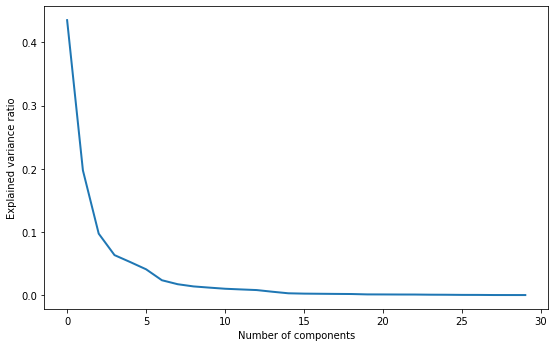

In [60]:
# Visualise explained variance ratio to the number of components

plt.figure(figsize = (10, 6))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_ratio_, linewidth = 2)
plt.axis('tight')
plt.xlabel('Number of components')
plt.ylabel('Explained variance ratio')

From the visualisation above, we can conclude that the optimal number of components is 4 using the elbow method.

In [61]:
# Instantiate PCA with 4 components and transform both training set and test set

pca = PCA(n_components = 4)
pca.fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

Accuracy: 95.80%
F1 score: 0.95


<AxesSubplot:>

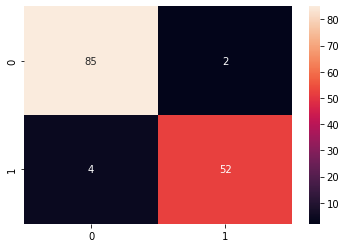

In [62]:
# Fit model to data and make predictions
rf = RandomForestClassifier(random_state = 42)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)

# Evaluate model accuracy 
accuracy = accuracy_score(Y_pred, Y_test) * 100
print("Accuracy: {:.2f}%".format(accuracy))
f1 = f1_score(Y_pred, Y_test)
print("F1 score: {:.2f}".format(f1))
cm = confusion_matrix(Y_pred, Y_test)
sns.heatmap(cm, annot = True, fmt = 'd')

With just 4 principal components, our model is able to achieve a similar accuracy score to that under the model-based feature selection technique where 9 different features were used to train the model.

However, despite the impressive dimensionality reduction abilities of the PCA, one of its disadvantages is that our predictor variables become less interpretable. In other words, PCA makes it more difficult for us to determine the features that are important in classifying cancer cells. This is largely due to the underlying algorithm of the PCA which turns the original features in the dataset into principal components which are linear combinations of different features.

Nevertheless, PCA remains a very robust technique in summarising high number of features into key components and thus allowing our model to capture all the important information in the dataset in order to make accurate predictions.

# 8. Conclusion

To summarise, feature selection and dimensionality reduction allow us to minimise the number of features in our dataset by only keeping features that are important. In other words, we want to retain features that contain the most useful information that is needed by our model to learn to make accurate predictions while discarding features that contain little to no information.

In this notebook, we have considered the following techniques:

* Variance inflation factor (95.80% accuracy with 25 features)
* Univariate feature selection (96.50% accuracy with 5 features)
* Recursive feature elimination (95.80% accuracy with 5 features)
* Model-based feature selection (97.08% accuracy with 9 features)
* Principal component analysis (95.80% with 4 principal components)


As we saw, despite using a significantly less number of features, we still managed to come very close the accuracy score under the base case scenario (97.08% accuracy) where all the features in the dataset were used to train our model.

In [37]:
jovian.commit()

<IPython.core.display.Javascript object>

[jovian] Updating notebook "kartikaye-madhok/breast-cancer-w-feature-selection-dimensionality" on https://jovian.ai
[jovian] Committed successfully! https://jovian.ai/kartikaye-madhok/breast-cancer-w-feature-selection-dimensionality


'https://jovian.ai/kartikaye-madhok/breast-cancer-w-feature-selection-dimensionality'